# Tanzanian Water Problems

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, \
cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score,\
confusion_matrix, classification_report, roc_auc_score, plot_confusion_matrix
# from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
RANDOM_STATE = 42

## Overview
Through DrivenData.org I have been tasked to predict whether or not a water point in Tanzania will need repairs. I am to use data telling me about location, what type of pump is being used and how its being managed in order to predict if it needs repairs or not. I use a Decision Tree Classifier that has been tuned to this data. I end up with more false positives than I would like as that means my model predicted the water point doesn't need repair, when in fact it does. This means more Tanzanians will go without water than I want.

## Business Problem
Tanzania has issues providing clean water to its population of over 57,000,000. Through a competition on DrivenData.org I have been tasked to analyze and predict which water pumps will need to be repaired in the future. Understanding what water pumps will need repairs can improve maintenace costs and time, and ensure the availability of clean water to Tanzanians.

## Data
Describe the data being used for this project.
The data I am using was sourced from Taarfia and The Tanzanian Ministry of Water. Given that this data is from a competition I know that it perfectly relates to the business problem. The data gives information about the location of the water point, what type of pump is being used, how its being managed and when it was installed. Using this information I need to predict whether a pump is functional, needs some repairs or doesn't work at all. Please look at [this notebook](./MaidenVoyage.ipynb) for more information about the data and cleaning.

## Method
First to analyze I dove into looking through all the value counts for my variables. Looking to figure out which columns I was going to use. What I was looking for was medium variety, high null value count, checking for null replacement values etc. This was a ternary classification problem however I converted it to a binary classification problem to save on time. After cleaning I decided to go with a simple GridSearchCV Decision Tree Classifier. I did a simple model instead of a more complicated one because I want to know which variables are affecting my model the most. My main step was hyperparameter tuning of which the results and details for can be found [here](./Hyperparameter_tuning.ipynb). I used my results as a starting point for GridSearchCV to save on computation. The results of which are found below.

In [12]:
def performance(y_true, y_predict):
    """ 
    Calculates and returns the two performance scores between 
    true and predicted values - first R-Squared, then accuracy
    From Regression Trees and Model Optimization - Lab
    """

    f1 = f1_score(y_true, y_predict)
    accuracy = accuracy_score(y_true, y_predict)
    roc_auc = roc_auc_score(y_true, y_predict)

    return [f1, accuracy, roc_auc]
def get_score(model, x_train, x_test, y_train, y_test):
    """
    Returns score from any given model and train test split data
    """
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score = performance(y_test, y_pred)
    return score

In [13]:
x_train = pd.read_csv('../Data/processed_varibles_train.csv')
y_train = pd.read_csv('../Data/processed_target_train.csv')
x_test = pd.read_csv('../Data/processed_varibles_test.csv')
y_test = pd.read_csv('../Data/processed_target_test.csv')

In [14]:
dt_param_grid = {
    'max_depth' : [12, 13, 14, 15],
    'min_samples_split' : [20, 23, 26],
    'min_samples_leaf' : [9, 10, 11, 12, 13],
    'max_features' : [0.2, 0.25, 0.35, 0.4, 0.9 ]
}

In [15]:
dt_clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3,
                              return_train_score=True)
dt_grid_search.fit(x_train, y_train)


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [12, 13, 14, 15],
                         'max_features': [0.2, 0.25, 0.35, 0.4, 0.9],
                         'min_samples_leaf': [9, 10, 11, 12, 13],
                         'min_samples_split': [20, 23, 26]},
             return_train_score=True)

In [16]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(x_test, y_test)
print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print(f"Optimal Parameters: {dt_grid_search.best_params_}")
dt_grid_search.best_score_

Mean Training Score: 83.06%
Mean Test Score: 81.52%
Optimal Parameters: {'max_depth': 14, 'max_features': 0.9, 'min_samples_leaf': 10, 'min_samples_split': 20}


0.8100838193581286

In [17]:
final_dt_clf = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=15,
                                     max_features=0.4, min_samples_leaf=12, 
                                     min_samples_split=26)
final_dt_clf.fit(x_train, y_train)
y_preds = final_dt_clf.predict(x_test)
score = performance(y_test, y_preds)
score

[0.8502899832890985, 0.8067994418368641, 0.7804421790749851]

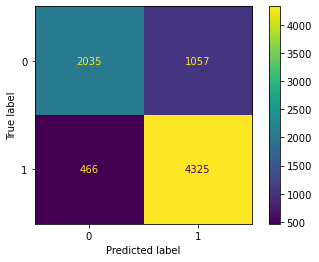

In [18]:
plot_confusion_matrix(final_dt_clf, x_test, y_test)

In [19]:
Feature_importance = {}
for i in range(len(x_train.columns.to_list())):
    Feature_importance[x_train.columns.to_list()[i]] = \
    round(final_dt_clf.feature_importances_[i], 8)

In [20]:
{k: v for k, v in sorted(Feature_importance.items(),
                         key=lambda item: item[1], reverse=True)}

{'quantity_dry': 0.1787968,
 'extraction_type_class_other': 0.17081162,
 'quantity_enough': 0.09884527,
 'latitude': 0.0616917,
 'construction_year': 0.05544314,
 'longitude': 0.0545806,
 'population': 0.0328143,
 'payment_type_never pay': 0.03056537,
 'gps_height': 0.02723295,
 'region_code': 0.02080247,
 'district_code': 0.01976922,
 'extraction_type_class_motorpump': 0.01945212,
 'waterpoint_type_other': 0.0166093,
 'waterpoint_type_communal standpipe': 0.01621265,
 'extraction_type_class_submersible': 0.01605129,
 'management_vwc': 0.01482377,
 'source_type_rainwater harvesting': 0.01358856,
 'waterpoint_type_improved spring': 0.00952197,
 'management_company': 0.0090905,
 'source_class_groundwater': 0.0075334,
 'id': 0.00735166,
 'source_type_spring': 0.006911,
 'basin_Internal': 0.00649281,
 'waterpoint_type_communal standpipe multiple': 0.00550914,
 'water_quality_unknown': 0.00525135,
 'permit_True': 0.00505037,
 'permit_False': 0.00493979,
 'basin_Lake Nyasa': 0.00484449,
 'pa

## Results
I ended with an accuracy score of 0.8026 so I can confidently say that this model would help with improving maintenace costs and time, and ensure the availability of clean water to Tanzanians. My confusion matrix tells me that I have a lot more false postives that false negatives. This is due to me not converting my this back to a ternary classification problem. Even so this model is still useful to the Tanzanian Ministry of Water in prediciting whether or not a water point needs repairs or not. 